# FAQUAD in DQD with 2HH including the three states

In this notebook we study the FAQUAD protocol applied to a DQD array populated with 2 heavy holes. The Hamiltonian that define the system is

$$
H=\left(\begin{array}{ccc}
\left|T_{-}(1,1)\right\rangle & |S(1,1)\rangle & |S(0,2)\rangle \\
-E_{Z} & \lambda_1 & \lambda_2 \\
\lambda_1 & 0 & \sqrt{2} \tau \\
\lambda_2 & \sqrt{2} \tau & \varepsilon+u
\end{array}\right)
$$

where $E_Z=g^*\mu_B B$ is the Zeeman splitting, $\tau$ ($t_F$) is the spin-conserving (spin-flip) tunnnelling, $u$ the intradot Coulomb interaction and $\varepsilon\equiv\varepsilon_2-\varepsilon_1$ the detuining between the dot. In fact, to symplify the results we set $\varepsilon_1=-\varepsilon_2$. The tunnelings we will set to be proportional as $\lambda_1=\lambda_2/100$ and $\lambda_2=\tau*0.4$.

Magic lines for reloading my custum funtions each time a cell is executed. This allows me to make changed in these functions without need of restarting the kernel to apply them in this notebook. The figure of matplotlib are set to be interative.

In [1]:
%load_ext autoreload
%autoreload 1
%aimport general_functions, plotting_functions, hamiltonians
%matplotlib notebook

Import all the necessary functions

In [2]:
import numpy as np
from hamiltonians import hamiltonian_2QD_1HH_Lowest, hamiltonian_2QD_1HH_All_molecular
from general_functions import (compute_eigensystem, compute_adiabatic_parameter, compute_parameters_interpolation,
                               compute_period, solve_system_unpack,sort_solution, create_hypermatrix, decoherence_test,
                               compute_limits, solve_system, solve_system_unpack_qutip, save_data)
from plotting_functions import modify_plot, save_figure, cycle_color
import matplotlib.pyplot as plt
from multiprocessing import Pool
from tqdm.notebook import tqdm
from scipy.constants import h, e
import scipy.fftpack
from scipy.integrate import romb
import matplotlib as mpl
from matplotlib import cm
import qutip as qt
from scipy.signal import savgol_filter

styles=['science']
prefix='./stylelib/'
sufix='.mplstyle'

for i in range(len(styles)):
    styles[i]=prefix+styles[i]+sufix

plt.style.use(styles)

Here we define all the constants of the system

In [3]:
hbar=((h / e) / (2 * np.pi)) * 10 ** 6 * 10 ** 9  # Value for the reduced Plank's constant [ueV * ns]
g=1.35 # g-factor fo the GaAs
muB=57.883 # Bohr magneton (ueV/T)
B=0.015 # Magnetic field applied (T)
ET = g * muB * B # Zeeman spliting (ueV)
tau = 0.25 # Sping-conserving (ueV)
l2 = 0.1 # Spin-flip tunneling (ueV)
l1 = l2/100 # Spin-flip tunneling (ueV)
u = 2000  #Intradot interaction (ueV)
Gamma = 0 #Dephasing parameters (1/ns)
hamiltonian=hamiltonian_2QD_1HH_Lowest
print(ET)

limit1 = 0.9999
limit2 = 0.9999
state_1 = 0
state_2 = 1
adiabatic_state = 1

eps_vector=np.linspace(-25,650,5*10**4)*ET-u

parameters = [eps_vector, u, ET, tau,l1, l2] # List with the parameters of the system

lim_T, lim_S = compute_limits(hamiltonian, parameters, limit1, limit2, state_1, state_2,
                              adiabatic_state, eps_vector, [tau], 0, 3,filter_bool=False)

print((lim_T+u)/ET)
print((lim_S+u)/ET)

1.1721307500000002
[-10.0552011]
[30.16210324]


In [4]:
temp = (lim_S+u)/ET-(lim_T+u)/ET
print((lim_S+u)/ET+temp*0.04)

[31.77079542]


<IPython.core.display.Javascript object>


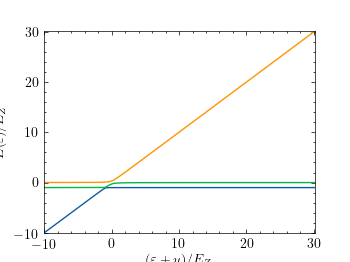

In [5]:
#Create the vector for eps
n_eps = 2 ** 15 + 1  # This number of elements is requiered for the romb method of integration used below
eps_vector = np.linspace(lim_T[0], lim_S[0], n_eps)

parameters = [eps_vector, u, ET, tau,l1, l2] # List with the parameters of the system


labels=[r'$(\varepsilon+u)/E_Z$',r'$E(\varepsilon)/E_Z$']  #Labels of the figure

#Compute and plot the eigenenergies of the system
energies, states, fig, ax = compute_eigensystem(parameters, hamiltonian, plot=True,x_vector=(eps_vector + u) / ET,
                                                normalization=ET, labels=labels)

#ax.autoscale(tight=True)

In [6]:
#This cell modify the plot to make it look better when saved into a .eps file
save=False # Parameter that control is the function must be saved

if save:
    modify_plot(ax,fig=fig,figsize=[7,5],x_ticks_vector=np.arange(-limit_eps,limit_eps+1,10))
    fig.tight_layout()
    
    annotation_size=16
    
    ax.text(4.1,3.7,r'$|S(0,2)\rangle$',{'color':'tab:green','fontsize':annotation_size})
    ax.text(4.1,0,r'$|S(1,1)\rangle$',{'color':'tab:orange','fontsize':annotation_size})
    ax.text(4.1,-1,r'$|T_-(1,1)\rangle$',{'color':'tab:blue','fontsize':annotation_size})
    
    ax.text(-3,-3.5,r'$|S(0,2)\rangle$',{'color':'tab:blue','fontsize':annotation_size})
    ax.text(-3.8,0.25,r'$|S(1,1)\rangle$',{'color':'tab:green','fontsize':annotation_size})
    ax.text(-3.8,-0.75,r'$|T_-(1,1)\rangle$',{'color':'tab:orange','fontsize':annotation_size})
    
    
    #lines=ax.lines
    #lines[2].set_linestyle('--')
    save_figure(fig,'eigenenergies_2QD_2HH_w_SOC', overwrite=save)

The adiabatic paramer is defined, in a multi-level system, as

$$
c=\hbar\sum_{k\neq i}\left|\frac{\langle \phi_i(t)|\partial_t\phi_k(t)\rangle}{E_i(t)-E_k(t)}\right|
$$

where the index $i$ denotes the initial eigenstate. Using the chain rule we can obtain

$$
ct_f\equiv \tilde{c}=\int_{\varepsilon(0)}^{\varepsilon(t_f)}d\varepsilon\left(\sum_{k\neq i}\left|\frac{\langle \phi_i(t)|\partial_\varepsilon\phi_k(t)\rangle}{E_i(t)-E_k(t)}\right|\right)
$$

The lower $c$, the more adiabatic is the transition. After obtaining a result for $\tilde{c}$, we can solve the EDO

$$
\dot{\varepsilon}=\frac{c}{\hbar}\left(\sum_{k\neq i}\left|\frac{\langle \phi_i(t)|\partial_\varepsilon\phi_k(t)\rangle}{E_i(t)-E_k(t)}\right|\right)^{-1}
$$

to obtain the dependence of $\varepsilon$. To symplify the result we can define the dimensionless parameter $s\equiv t/t_F=[0,1]$.

In [7]:
partial_hamiltonian = np.zeros([n_eps, 3, 3], dtype=complex)
partial_hamiltonian[:, 2, 2] = 1


#Compute the factors (\sum...) and the c_tilde parameters
factors, c_tilde = compute_adiabatic_parameter(eps_vector, states, energies, 1, hbar=hbar,
                                               partial_Hamiltonian=partial_hamiltonian)
print('c_tilde = {}'.format(c_tilde))

#Solve the EDO to obtain the dependency of eps with the paramer s
s, eps_sol = compute_parameters_interpolation(eps_vector, factors, c_tilde, method_1=False, nt=10**6)

c_s=hbar * romb(factors, dx=np.abs(eps_vector[0] - eps_vector[1]), axis=0)
print(c_s)

c_tilde = 4.335045602301959
[3.4495018 0.8855438]


<IPython.core.display.Javascript object>


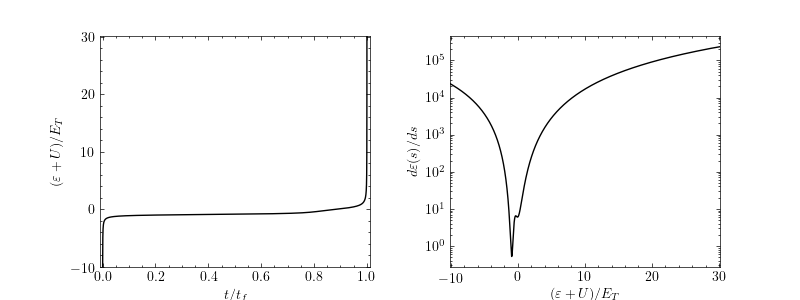

In [8]:
save=False # Parameter that control is the function must be saved

derivative=np.gradient(eps_sol,s)
derivative_filtered = savgol_filter(derivative, 21, 3)

#Initialize the figure with two subplots
fig, [ax1,ax2] = plt.subplots(figsize=(8,3),ncols=2)
fig.subplots_adjust(wspace=0.3)

#Plot the detunning in terms of s
ax1.plot(s, (eps_sol + u) / ET,'k')
ax1.set_xlabel(r'$t/t_f$')
ax1.set_ylabel(r'$(\varepsilon+U)/E_T$')
ax1.set_xlim([-0.01,1.01])
ax1.set_ylim([(lim_T[0]+u)/ET, (lim_S[0]+u)/ET])

# plot the derivate of thje detunning in terms of itself
ax2.plot((eps_sol+u)/ET,derivative_filtered,'k')
ax2.set_yscale('log')
ax2.set_xlabel(r'$(\varepsilon+U)/E_T$')
ax2.set_ylabel(r'$d\varepsilon(s)/ds$')
ax2.set_xlim([(lim_T[0]+u)/ET, (lim_S[0]+u)/ET])


#If the figure must be saved then it is modified and saved if the parameter overwrite is set to True
if save:
    ax1.text(-0.3,32,'a)',{'fontsize':15})
    ax2.text(-20,390616.7,'b)',{'fontsize':15})
    
    modify_plot(ax1,label_size=13,tick_label_size=11, lines_width=2)
    ax1.set_xlim([-0.05,1.05])
    
    modify_plot(ax2,label_size=13, tick_label_size=11,lines_width=2)
    ax2.set_ylim([np.min(derivative_filtered)*0.6,np.max(derivative_filtered)])
    
    save_figure(fig,'FAQUAD_detuning_2QD_2HH', overwrite =save, dic='thesis', extension='pdf');

The FAQUAD protol has a oscillatory behaviour with a period given by $T=2\pi/\Phi$ where

$$
\Phi=\frac{1}{t_f\hbar}\int_0^{t_f}dt E_{\text{gap}}(t)=\frac{1}{\hbar}\int_0^1ds E_{\text{gap}}(s)
$$

In [204]:
#This cell compute the value for the period of the oscilations
eps_interpolated=qt.Cubic_Spline(0,1,eps_sol)

parameters=[eps_interpolated, u, ET, tau,l1, l2]
T=compute_period(eps_interpolated,hamiltonian,parameters, hbar, index=0, state=1)
print(T)

[10.45396444  3.67869583]


Now we must solve the system, what can be done using the density matrix an the EDO

$$
\frac{d\rho}{d t}=-\frac{i}{\hbar}[H,\rho]
$$

The system is initiate in the state $|T_-(1,1)\rangle$, that is only the first enty of the matrix is non-zero $\rho(0,0)=1$.

10.0%. Run time:   0.03s. Est. time left: 00:00:00:00
20.0%. Run time:   0.06s. Est. time left: 00:00:00:00
30.0%. Run time:   0.09s. Est. time left: 00:00:00:00
40.0%. Run time:   0.13s. Est. time left: 00:00:00:00
50.0%. Run time:   0.16s. Est. time left: 00:00:00:00
60.0%. Run time:   0.19s. Est. time left: 00:00:00:00
70.0%. Run time:   0.23s. Est. time left: 00:00:00:00
80.0%. Run time:   0.26s. Est. time left: 00:00:00:00
90.0%. Run time:   0.28s. Est. time left: 00:00:00:00
Total run time:   0.32s


<IPython.core.display.Javascript object>


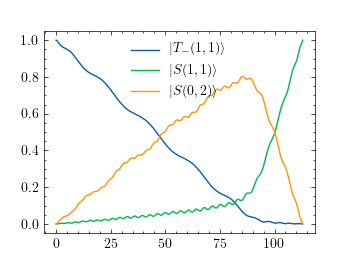

0.9997282374043884


In [164]:
H1=hamiltonian(*[0, u, ET, tau,l1, l2])/hbar
H1=qt.Qobj(H1)
H2=np.zeros([3,3],dtype=complex)
H2[2,2]=1/hbar
H2=qt.Qobj(H2)

psi0 = qt.basis(3, 0)

n_t=10**3

time = np.linspace(0, 112.88, n_t, endpoint=True)  # Time vector in which compute the solution of the population

eps_interpolated=qt.Cubic_Spline(time[0],time[-1],eps_sol)

H=[H1,[H2,eps_interpolated]]

solution=qt.mesolve(H, psi0, time,progress_bar=True)

states = np.zeros([3, len(time)], dtype=complex)

for j in range(0, len(time)):
    states[:, j] = solution.states[j].full()[:, 0]
    
#names=[r'$|T_+(1,1)\rangle$',r'$|T_0(1,1)\rangle$',r'$|T_-(1,1)\rangle$',r'$|S(0,2)\rangle$',r'$|S(1,1)\rangle$']
names=[r'$|T_-(1,1)\rangle$',r'$|S(1,1)\rangle$',r'$|S(0,2)\rangle$']
    
plt.figure()
for i in range (0,3):
    plt.plot(time,np.abs(states[i,:])**2, label=names[i])

plt.legend()

print(np.abs(states[1,-1])**2)

In [193]:
%%time

# Array for the values for the total times for the protocol that we will use
n_tf = 1000
tf_vec = np.linspace(0.01, 100, n_tf)

n_t = 10**3

H1=hamiltonian(*[0, u, ET, tau, l1, l2])/hbar
H1=qt.Qobj(H1)
H2=np.zeros([3,3],dtype=complex)
H2[2,2]=1/hbar
H2=qt.Qobj(H2)

psi0 = qt.basis(3, 0)

    
#The computation will be done with an async multiprocessing map
if __name__ == '__main__': # This line is necesary in order to use multiprocessing in windows
        chunksize=500
        results=[] #Empty list in which save the async results
        pbar1 = tqdm(total=int(np.ceil(n_tf/chunksize)), desc='Chunks')
        pbar2 = tqdm(desc='Processing')
        for i in range (0,int(n_tf/chunksize)):
            
            initial=i*chunksize
            if i==n_tf%chunksize-1:
                final=-1
            else:
                final=initial+chunksize
            
            #Create the list of lists with all the parameters that will be used in the parallel computation
            args=[] #Empty list in which save the sorter list of parameters
            for j in range (initial,final):# Iterate over all the final times
                time = np.linspace(0, tf_vec[j], n_t, endpoint=True)  # Time vector in which compute the solution of the population
                eps_vec=qt.Cubic_Spline(time[0],time[-1],eps_sol)
                H=[H1,[H2,eps_vec]]
                temp=[j,H, psi0, time, {'dim':3}] # List of parameters and default parameters as a dic
                args.append(temp) # Append the list
            
            
            #Initialice progress bar
                        
            pool = Pool() #Initialice the pool for mutiplicesing
            pbar2.reset(total=final-initial)
            for j, result in enumerate(pool.imap_unordered(solve_system_unpack_qutip,args, chunksize=4), 1): #Iterate over all the desired parameters
                results.append(result) # Save the result
                pbar2.update() #Update the progress bar
            pool.terminate() #Terminate the pool           
            pbar2.refresh() #   Force refresh the display of the progess bar
            pbar1.update()
        
pbar1.refresh()
pbar1.display(bar_style='success')

results_sort=sort_solution(results) # Sort the asyn results

results=0
args=[] #Empty list

probabilities=[]
fidelity=np.zeros(n_tf)

for i in range (0,n_tf):
    temp=results_sort[i]
    
    probabilities.append(np.abs(temp)**2)
    
    fidelity[i]=probabilities[i][1,-1]

Wall time: 4min 4s


In [23]:
pool.terminate()

In [156]:
#save_data('FAQUAD_DQD_1HH',[[0, u, ET, tau, l1, l2],tf_vec,eps_sol,results_sort,c_s,T,['parameters','tf_vec','eps_sol','results','c_s', 'T']])

Do you want to overwrite the file (data/FAQUAD_DQD_1HH.npy)?  [y]/n: 


# %%time

# Array for the values for the total times for the protocol that we will use
n_tf = 1000
tf_vec = np.linspace(0.1, 400, n_tf)

n_t = 2*10**3

density0 = np.zeros([3, 3], dtype=complex)  # Initialize the variable to save the density matrix
density0[0, 0] = 1  # Initially the only state populated is the triplet (in our basis the first state)

#Initialice progress bar
pbar = tqdm()
pbar.reset(total=n_tf)

#Create the list of lists with all the parameters that will be used in the parallel computation
args=[] #Empty list in which save the sorter list of parameters
for i in range (0,n_tf):# Iterate over all the final times
    time = np.linspace(0, tf_vec[i], n_t, endpoint=True)  # Time vector in which compute the solution of the population
    temp=[i,time, density0, [eps_sol, u, ET, tau, l1, l2], hamiltonian_2QD_1HH_Lowest, 
          {'normalization':tf_vec[i],'atol': 1e-7, 'rtol': 1e-5}] # List of parameters and default parameters as a dic
    args.append(temp) # Append the list

#The computation will be done with an async multiprocessing map
if __name__ == '__main__': # This line is necesary in order to use multiprocessing in windows
        results=[] #Empty list in which save the async results
        pool = Pool() #Initialice the pool for mutiplicesing
        for i, result in enumerate(pool.imap_unordered(solve_system_unpack,args, chunksize=1), 1): #Iterate over all the desired parameters
            results.append(result) # Save the result
            pbar.update() #Update the progress bar
        pool.terminate() #Terminate the pool
pbar.refresh(); #   Force refresh the display of the progess bar

results_sort=sort_solution(results) # Sort the asyn results

density_matrix=[]
probabilities=[]

for temp in results_sort:
    density_matrix.append(temp[0])
    probabilities.append(temp[1])

Our goal is to transfer the system form $T_-(1,1)$ to $S(1,1)$, so we define the fidelity of the protocol as

$$
\mathcal{F}\equiv|\langle S(1,1)|\Psi(t=t_f)\rangle
$$


<IPython.core.display.Javascript object>


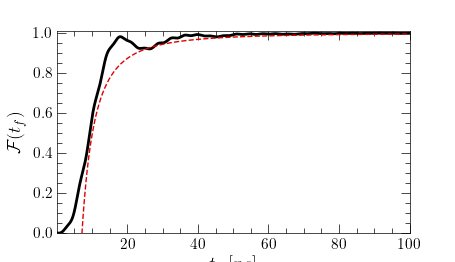

Figure saved


In [194]:
#Extract the index for the first maximum
maximum = False # Variable to check if the maximum is been reached
counter = 0 #Variable to count the index
window=10
while not maximum: #While the maximum is not reached iterate over the rest of the indices
    if np.all(fidelity[counter] > fidelity[counter + 1:counter+window]):#If a maximum is reached
        index_max = counter # Save the index
        maximum = True #Exit the while loop
    else: #If the maximum is not reached
        counter += 1 #Check the next index
    
save = True  # Parameter that control is the function must be saved

fig = plt.figure(figsize=(3.5*1.3, 2.625))  # Initialize the figure
ax = fig.add_subplot(1, 1, 1)

ax.plot(tf_vec, fidelity,'k')  # Plot the fidelity

#Modify the limits
ax.set_xlim(tf_vec[0], tf_vec[-1])
ax.set_ylim(0, 1.01)

#Set the labels
ax.set_xlabel(r'$t_f\; [ns]$')
ax.set_ylabel(r'$\mathcal{F}(t_f)$')

# for i in range(0, 3):
#     temp_value=np.abs(tf_vec-(tf_vec[index_max] + np.max(T) * i))
#     temp_index=np.where(temp_value==np.min(temp_value))
#     ax.scatter(tf_vec[index_max] + np.max(T) * i, fidelity[temp_index], c='b', marker='x', zorder=10, linewidth=2)
    
ax.plot(tf_vec, 1-4*np.sum(c_s**2)/tf_vec**2, 'r--', label=r'$1-4\sum\tilde{c}_i^2/t_f^2$',color=cycle_color(1))

# ax.legend()

#If the figure must be saved then it is modified and saved if the parameter overwrite is set to True
if save:
    modify_plot(ax, label_size=13, tick_label_size=11, lines_width=[2,1], y_ticks_vector=np.arange(0,1.1,0.2), colors_bool=False)
    ax.set_ylim(0, 1.01)
    save_figure(fig,'FAQUAD_2QD_Results',overwrite=save, dic='thesis');

In [195]:
#Compute the index where the maximum fidelity is obtained in the first half of the final times
index=np.where(fidelity==np.max(fidelity[0:int(n_tf/2)]))[0][0] # Index where the maximum fidelity have been reached

# Print the values obtained
print('The maximum fidelity in the first peack is {:.10f}, reached at t_f = {:.3f} ns.\nThis corresponds to the index {}.'.
      format(fidelity[index_max],tf_vec[index_max],index_max))

The maximum fidelity in the first peack is 0.9814809694, reached at t_f = 18.026 ns.
This corresponds to the index 180.


In [196]:
np.max(fidelity)

0.9995349204847299

<IPython.core.display.Javascript object>


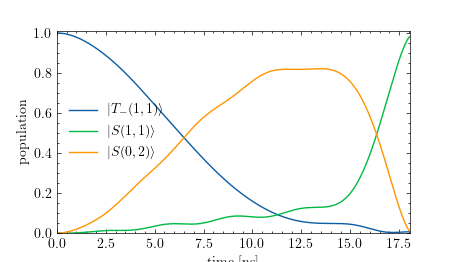

In [197]:
# Plot of the evolution of the system for the final at at which we have obtained the maxium fidelity

save= False # Parameter that control is the function must be saved

#Initialize the figure
fig=plt.figure(figsize=(3.5*1.3, 2.625))
ax=fig.add_subplot(1,1,1)

t = np.linspace(0, tf_vec[index_max], n_t) # Time array 

#Plot the population of the three states
ax.plot(t,probabilities[index_max][0,:],label=r'$|T_-(1,1)\rangle$')
ax.plot(t,probabilities[index_max][1,:],label=r'$|S(1,1)\rangle$')
ax.plot(t,probabilities[index_max][2,:],label=r'$|S(0,2)\rangle$')

#Set the legend and labels
ax.legend()
ax.set_xlabel('time [ns]')
ax.set_ylabel('population')

#Modify the limits
ax.set_xlim([0,t[-1]])
ax.set_ylim([0,1.01])


#If the figure must be saved then it is modified and saved if the parameter overwrite is set to True
if save:
    modify_plot(ax, label_size=13, tick_label_size=11, lines_width=1.5, legend=True, legend_size=9, styles=False)
    save_figure(fig,'states_evolution_1', overwrite=save, dic='thesis');

Our second task is to populate the double occupation singlet state as little as possible. For this verify the maximum population of the state in terms of the final time.

<IPython.core.display.Javascript object>


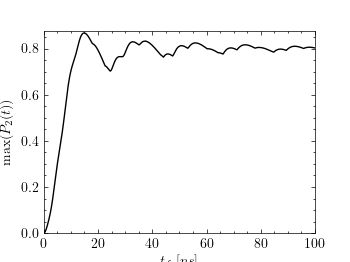

In [198]:
save=False

prob_middle=np.zeros(n_tf)
for i in range (0, n_tf):
    prob_middle[i]=np.max(probabilities[i][2,:])

fig=plt.figure()
ax=fig.add_subplot(1,1,1)

ax.plot(tf_vec, prob_middle,'k')

ax.set_xlabel(r'$t_f\; [ns]$')
ax.set_ylabel(r'$\max(P_2(t))$')

ax.set_xlim([0, tf_vec[-1]])
ax.set_ylim([0,np.max(prob_middle)*1.01])

if save:
    modify_plot(ax, label_size=15, tick_label_size=12, lines_width=2)
    save_figure(fig,'max_pop_S22', overwrite=save);

At all times the trace of the density matrix must be equals to the unity. Due to some numerial error in the solution of the dinamy of the system this is not exactly fulfilled. In the next figure we show the errors that deviate the trace to the unity

<IPython.core.display.Javascript object>


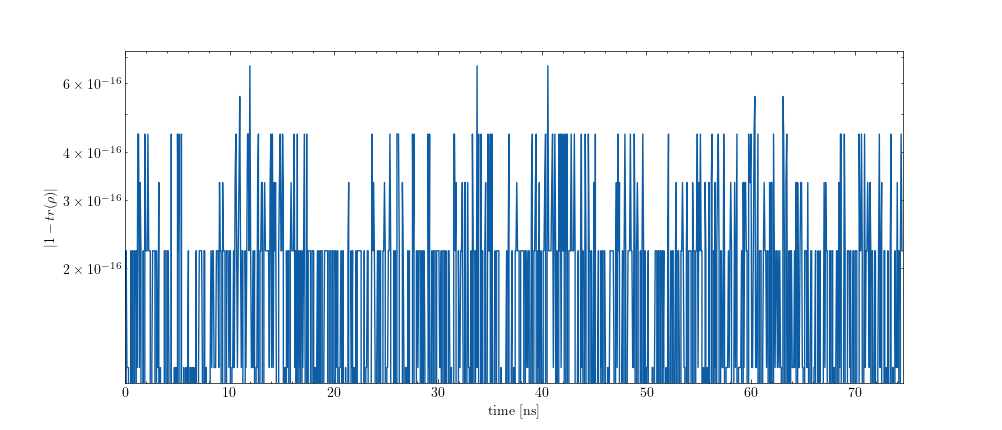

In [96]:
plt.figure() #Initialice figure
plt.plot(t,np.abs(1-np.sum(probabilities[index_max],axis=0))) #Plot |1-tr(ρ)| at the times in which we have solved the system

plt.yscale('log') # Set the y-axis in log scale

plt.xlabel('time [ns]')
plt.ylabel(r'$|1-tr(\rho)|$')

# Modify limits
plt.xlim([0, tf_vec[index_max]]);

<IPython.core.display.Javascript object>


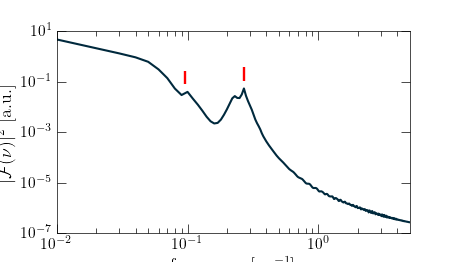

Figure saved


In [213]:
save=True

fig=plt.figure(figsize=(3.5*1.3, 2.625))
ax=fig.add_subplot(1,1,1)

increase=0

x_vector=tf_vec
data=np.gradient(fidelity, x_vector)
data=np.append(data,np.zeros(increase))
x_vector=np.append(x_vector, tf_vec[:increase]+tf_vec[-1])
    
yf = scipy.fftpack.fft(data)/np.sqrt(len(data))
xf = scipy.fftpack.fftfreq(len(yf), d=(x_vector[1]-x_vector[0]))

yf=yf[:len(yf)//2]
xf=xf[:len(xf)//2]


index=len(yf)
yf_filtered = savgol_filter(np.abs(yf), 201, 5)

yf_mix=np.append(yf[:index],yf_filtered[index:])
    
ax.plot(xf,np.abs(yf_mix/(2*np.pi*xf*1j+1e-5)),'k')


ax.set_xlim(1e-2,np.max(xf))
ax.set_ylim(1e-7,1e1)

ax.set_xlabel('frequency '+r'$[ns^{-1}]$')
ax.set_ylabel(r'$|\mathcal{F}(\nu)|^2$'+'  [a.u.]')
ax.set_yscale('log')
ax.set_xscale('log')

for i in range (0,2):
    temp_value=np.abs(xf-1/T[i])
    temp_index=np.where(temp_value==np.min(temp_value))
    value=np.abs(yf/(2*np.pi*xf*1j+1e-5))[temp_index]
    
    ax.vlines(1/T[i],value*2,value*7,zorder=10, linewidth=1.7, color='r')

if save:
    modify_plot(ax, label_size=13, tick_label_size=11, lines_width=1.5)
    save_figure(fig,'frecuency_spectrum', overwrite=save, dic='thesis');

<IPython.core.display.Javascript object>


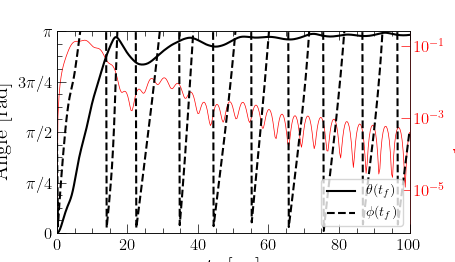

In [200]:
step=3

save=False

states=results_sort

phi=np.angle(np.array([states[i][0,-1]*np.conjugate(states[i][1,-1]) for i in range (n_tf)]))
r=np.sqrt(np.array([np.abs(states[i][0,-1])**2+np.abs(states[i][1,-1])**2 for i in range (n_tf)]))
theta=2*np.arccos(np.abs(np.array([states[i][0,-1] for i in range (n_tf)]))/r)

phi=phi[::step]+np.pi
r=r[::step]
theta=theta[::step]


# phi[np.where(phi>np.pi)]-=2*np.pi

phi[0]=np.pi/2

x=r*np.cos(phi)*np.sin(theta)
y=r*np.sin(theta)*np.sin(phi)
z=r*np.cos(theta)

fig, ax1 = plt.subplots(figsize=(3.5*1.3, 2.625))

ax1.plot(tf_vec[::step],theta,'k', label=r'$\theta(t_f)$')
ax1.plot(tf_vec[::step],phi,'k--', label=r'$\phi(t_f)$')
ax1.set_ylabel('Angle [rad]')
ax1.set_xlabel(r'$t_f\; [ns]$')

y_ticks=np.linspace(0,np.pi,5,endpoint=True)
y_ticks_labels=[r'$0$',r'$\pi/4$',r'$\pi/2$',r'$3\pi/4$',r'$\pi$',]
ax1.yaxis.set_ticks(y_ticks)
ax1.set_yticklabels(y_ticks_labels)

ax2=ax1.twinx()
ax2.set_zorder(ax1.get_zorder()-1)

ax2.plot(tf_vec[::step],1-r,'r', linewidth=0.5)
ax1.patch.set_visible(False)

ax2.set_xlim([0,tf_vec[-1]])
ax2.set_ylabel(r'$1-r$')
ax2.set_yscale('log')
ax2.spines['right'].set_color('red')
ax2.yaxis.label.set_color('red')
ax2.tick_params(axis='y',which='both', colors='red')

#plt.tight_layout()
modify_plot(ax1, label_size=15, tick_label_size=12, lines_width=1.5, legend=True, colors_bool=False, legend_size=15)
modify_plot(ax2, label_size=15, tick_label_size=12, lines_width=0.5, colors_bool=False)
ax1.legend(frameon=True, loc=4)
ax1.set_ylim([0,np.pi])
ax1.set_xlim([0,tf_vec[-1]])
save_figure(fig,'Angles_Bloch_sphere',overwrite=save, dic='thesis', extension='pdf');

<IPython.core.display.Javascript object>


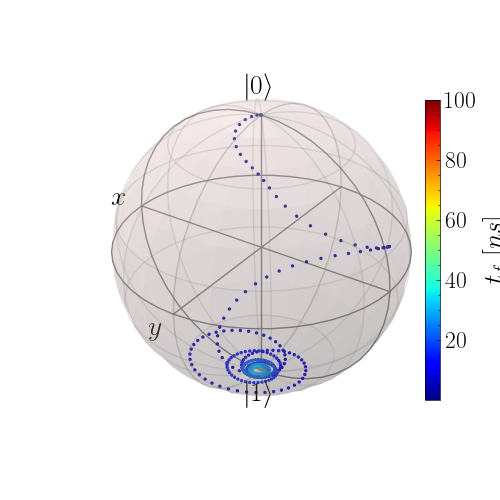

In [202]:
save=False

from mpl_toolkits.mplot3d import Axes3D
fig, ax = plt.subplots(figsize=(5, 5), subplot_kw=dict(projection='3d'))


nrm=mpl.colors.Normalize(tf_vec[0],tf_vec[-1])
colors=cm.jet(nrm(tf_vec))

b = qt.Bloch(fig=fig, axes=ax)
b.add_points([x,y,z],'m')
b.point_color=list(colors)
b.point_marker=['o']
b.point_size=[2]
b.render(fig=fig, axes=ax)
b.view=[0,0]

ax.view_init(elev=31, azim=34)

left, bottom, width, height = [0.85, 0.2, 0.03, 0.6]
ax2 = fig.add_axes([left, bottom, width, height])


cbar=mpl.colorbar.ColorbarBase(ax2, cmap=cm.jet,norm=nrm,orientation='vertical')
cbar.set_label(r'$t_f \;[ns]$', fontsize=19, labelpad=5)
cbar.ax.tick_params(labelsize=17)

if save:
    save_figure(fig,'Bloch_sphere', overwrite=save, extension='pdf');